<a href="https://colab.research.google.com/github/franciscovillaescusa/ML_lectures/blob/main/Lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### In this exercise we are going to use convolutional neural networks to extract cosmological information from 2D mass projected fields from 1,000 N-body simulations belonging to the CAMELS IllustrisTNG LH suite.

#### These maps contain the projected mass in a region of $25\times 25 \times 5 ~(h^{-1}{\rm Mpc})^3$. The idea is that the convolutional neural network is going to look for unique features or summnary statistics that will use to determine the value of $\Omega_{\rm m}$ and $\sigma_8$ from the maps themselves, without us computing summary statistics or any likelihood function.

#### The data is located in dropbox here:
[Data](https://www.dropbox.com/sh/vghnick9hr1gksr/AADPV4FMPsWpurnSl9kXZjp1a?dl=0)

#### Some slides about CNNs can be found here:

[CNNs](https://docs.google.com/presentation/d/1EP7U3QJrYvaQopYFjOYybEQ6s95FiFQeh5SWq6vs6Jc/edit?usp=sharing)


### Load the libraries

In [ ]:
import numpy as np
import sys,os,time
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

### If GPUs are available, use them

In [ ]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Available


### Load the data

In [ ]:
# load the maps
maps = np.load('Images_M_IllustrisTNG_LH_grid=64_z=0.00.npy')
print(maps.shape)

# load the parameter values
params = np.loadtxt('params_IllustrisTNG_maps.txt')
print(params.shape)

(15000, 64, 64)
(15000, 2)


### Get familiar with the data

In [ ]:
# select the first map
map0 = maps[0]
print('Map0 dimensions:',map0.shape)
print('%.3e < map0 < %.3e'%(np.min(map0), np.max(map0)))
print(map0)
print(params[0])

Map0 dimensions: (64, 64)
1.907e+09 < map0 < 2.444e+13
[[1.9231244e+10 1.6727726e+10 1.4641767e+10 ... 1.5229234e+11
  3.2197116e+10 2.3492391e+10]
 [1.3092933e+10 1.6298293e+10 1.5066103e+10 ... 1.0133546e+11
  3.1450460e+10 1.5090869e+10]
 [2.2257840e+10 3.8474117e+10 2.1472688e+10 ... 1.0981424e+11
  3.3890318e+10 1.8398728e+10]
 ...
 [1.8270138e+10 1.3947409e+10 1.4366807e+10 ... 6.2173590e+10
  5.6780755e+10 7.3579930e+10]
 [1.7102807e+10 3.8144778e+10 1.4743786e+11 ... 2.7589240e+11
  5.1694064e+10 2.3939469e+10]
 [2.5425111e+10 5.4379487e+10 2.7855690e+10 ... 7.4623156e+10
  3.1854307e+10 2.3992355e+10]]
[0.30899999 0.97899997]


### Plot one map

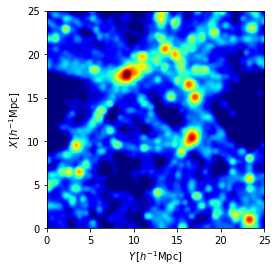

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
 
plt.ylabel(r'$X\,[h^{-1}{\rm Mpc}]$')
plt.xlabel(r'$Y\,[h^{-1}{\rm Mpc}]$')

plt.imshow(maps[0],cmap=plt.get_cmap('jet'),origin='lower',
           extent=[0, 25, 0, 25], interpolation='bicubic',
           norm = LogNorm(vmin=1e10,vmax=1e13))

plt.show()

### Define the value of the (hyper-)parameters

In [ ]:
f_maps         = 'Images_M_IllustrisTNG_LH_grid=64_z=0.00.npy' #file containing the maps
f_params       = 'params_IllustrisTNG_maps.txt'                #file with the cosmological parameters
maps_per_sim   = 15  #number of maps per simulation
batch_size     = 32
seed           = 2     #the data is randomly shuffled before being split into training, validation and testing. This set the random seed for that. 
lr             = 1e-4  #learning rate
dr             = 0.5   #dropout rate
hidden         = 4     #number of channels in the first CNN
wd             = 2e-4  #weight decay
epochs         = 100   #number of epochs to train the model
min_valid_loss = 1e7
f_model        = 'best_model_maps.pt'

### Define the data loader

In [ ]:
# This routine creates a dataset loader
# mode ---------> 'train', 'valid', 'test', 'all'. How to create the dataset
# f_maps -------> file containing the maps
# f_params -----> file containing the value of the cosmological parameters
# batch_size ---> number of elements in the batch
# seed ---------> the data is randomly shuffled before being split into training, validation and testing. This set the random seed for that. 
# maps_per_sim -> number of maps per simulation
def create_dataset(mode, f_SFRD, f_params, batch_size, seed, maps_per_sim):

    # create the class with the dataset
    data_set = make_dataset(mode, f_maps, f_params, seed, maps_per_sim)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)


# This class creates the dataset 
class make_dataset():

    def __init__(self, mode, f_maps, f_params, seed, maps_per_sim):

        # read the data
        maps   = np.load(f_maps)       #read the maps
        params = np.loadtxt(f_params)  #read value of the parameters

        # get the number simulations and the number of pixels per map
        sims     = maps.shape[0]//maps_per_sim
        x_pixels = maps.shape[1]    
        y_pixels = maps.shape[2]        

        # normalize the maps
        maps = np.log10(maps)
        mean = np.mean(maps, dtype=np.float64)
        std  = np.std(maps,  dtype=np.float64)
        maps = (maps - mean)/std

        # Normalize the value of the parameters
        min_params = np.min(params, axis=0)
        max_params = np.max(params, axis=0)
        params     = (params - min_params)/(max_params - min_params)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  size, offset = int(sims*0.70), int(sims*0.00)
        elif mode=='valid':  size, offset = int(sims*0.15), int(sims*0.70)
        elif mode=='test':   size, offset = int(sims*0.15), int(sims*0.85)
        elif mode=='all':    size, offset = int(sims*1.00), int(sims*0.00)
        else:                raise Exception('Wrong name!')

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a 
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        ids = np.arange(sims)
        np.random.shuffle(ids)
        ids = ids[offset:offset+size] #select indexes of the mode

        # get the indexes of the selected maps
        indexes = np.zeros(size*maps_per_sim, dtype=np.int32)
        count = 0
        for i in ids:
          for j in range(maps_per_sim):
            indexes[count] = i*maps_per_sim + j
            count += 1

        # get the corresponding maps and parameter values
        self.size   = size*maps_per_sim
        self.input  = torch.tensor(maps[indexes],   dtype=torch.float32)
        self.output = torch.tensor(params[indexes], dtype=torch.float32)

        # in pytorch, maps should have dimensions of [batch, channels, height, width]
        self.input.unsqueeze_(1)

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns 
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# get the data
train_loader = create_dataset('train', f_maps, f_params, batch_size, seed, maps_per_sim) #training data
valid_loader = create_dataset('valid', f_maps, f_params, batch_size, seed, maps_per_sim) #validation data
test_loader  = create_dataset('test',  f_maps, f_params, batch_size, seed, maps_per_sim) #test data

### Define the architecture of the model

In [ ]:
class model_a(nn.Module):
    
    def __init__(self, hidden, dropout_rate):
        super(model_a, self).__init__()
        
        # define the layers here
        # input: 1x64x64 ----------> output: hiddenx32x32
        self.C1 = nn.Conv2d(1,   hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')
        self.B1 = nn.BatchNorm2d(hidden)

        # input: hiddenx32x32 --------> output: 2*hiddenx16x16
        self.C2 = nn.Conv2d(hidden, 2*hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')
        self.B2 = nn.BatchNorm2d(2*hidden)
        
        # input: 4*hiddenx16x16 ----------> output: 8*hiddenx8x8
        self.C3 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')
        self.B3 = nn.BatchNorm2d(4*hidden)
        
        # input: 8*hiddenx8x8 ----------> output: 16*hiddenx4x4
        self.C4 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')
        self.B4 = nn.BatchNorm2d(8*hidden)
        
        # input: 16*hiddenx4x4 ----------> output: 32*hidden*x2x2
        self.C5 = nn.Conv2d(8*hidden, 16*hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')

        self.FC1  = nn.Linear(16*hidden*2*2, 2) 

        self.dropout   = nn.Dropout(p=0.5)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()


    def forward(self, image):

        x = self.LeakyReLU(self.B1(self.C1(image)))
        x = self.LeakyReLU(self.B2(self.C2(x)))
        x = self.LeakyReLU(self.B3(self.C3(x)))
        x = self.LeakyReLU(self.B4(self.C4(x)))
        x = self.LeakyReLU(self.C5(x))
        x = x.view(image.shape[0],-1)
        x = self.dropout(x)
        x = self.FC1(x)

        return x

class model_b(nn.Module):
    
    def __init__(self, hidden, dropout_rate):
        super(model_b, self).__init__()
        
        # define the layers here
        # input: 1x64x64 ----------> output: hiddenx32x32
        self.C0 = nn.Conv2d(1,   hidden, kernel_size=3, stride=1, padding=1,
                            bias=True, padding_mode='circular')
        self.C1 = nn.Conv2d(hidden, hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')
        self.B0 = nn.BatchNorm2d(hidden)
        self.B1 = nn.BatchNorm2d(hidden)

        # input: hiddenx32x32 --------> output: 2*hiddenx16x16
        self.C2 = nn.Conv2d(hidden,   2*hidden, kernel_size=3, stride=1, padding=1,
                            bias=True, padding_mode='circular')
        self.C3 = nn.Conv2d(2*hidden, 2*hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')
        self.B2 = nn.BatchNorm2d(2*hidden)
        self.B3 = nn.BatchNorm2d(2*hidden)
        
        # input: 4*hiddenx16x16 ----------> output: 8*hiddenx8x8
        self.C4 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            bias=True, padding_mode='circular')
        self.C5 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')
        self.B4 = nn.BatchNorm2d(4*hidden)
        self.B5 = nn.BatchNorm2d(4*hidden)
        
        # input: 8*hiddenx8x8 ----------> output: 16*hiddenx4x4
        self.C6 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            bias=True, padding_mode='circular')
        self.C7 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')
        self.B6 = nn.BatchNorm2d(8*hidden)
        self.B7 = nn.BatchNorm2d(8*hidden)
        
        # input: 16*hiddenx4x4 ----------> output: 32*hidden*x2x2
        self.C8 = nn.Conv2d(8*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            bias=True, padding_mode='circular')
        self.C9 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=4, stride=2, padding=1,
                            bias=True, padding_mode='circular')
        self.B8 = nn.BatchNorm2d(16*hidden)

        self.FC1  = nn.Linear(16*hidden*2*2, 2) 

        self.dropout   = nn.Dropout(p=0.5)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()


    def forward(self, image):

        x = self.LeakyReLU(self.B0(self.C0(image)))
        x = self.LeakyReLU(self.B1(self.C1(x)))
        x = self.LeakyReLU(self.B2(self.C2(x)))
        x = self.LeakyReLU(self.B3(self.C3(x)))
        x = self.LeakyReLU(self.B4(self.C4(x)))
        x = self.LeakyReLU(self.B5(self.C5(x)))
        x = self.LeakyReLU(self.B6(self.C6(x)))
        x = self.LeakyReLU(self.B7(self.C7(x)))
        x = self.LeakyReLU(self.B8(self.C8(x)))
        x = self.LeakyReLU(self.C9(x))
        x = x.view(image.shape[0],-1)
        x = self.dropout(x)
        x = self.FC1(x)

        return x        

# get the model and move it to the GPU
model = model_a(hidden, dr)  #architecture
model.to(device=device) #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

NameError: ignored

### Define the loss function and the optimizer

In [ ]:
criterion = nn.MSELoss()  #loss function. In this case MSE (mean squared error)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

### Train!!

In [ ]:
start = time.time()

# do a loop over all epochs
for epoch in range(epochs):
        
    # do training
    train_loss, points = 0.0, 0
    model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
    for maps_train, params_train in train_loader:  #do a loop over all elements in the training set

        # get the number of elements in the batch
        bs = maps_train.shape[0]   

        # move data to GPU
        maps_train   = maps_train.to(device) 
        params_train = params_train.to(device)  

        # compute the value predicted by the network 
        params_pred  = model(maps_train)

        # compute loss 
        loss = criterion(params_pred, params_train)

        # compute cumulative loss and number of examples used
        train_loss += loss.item()*bs
        points     += bs

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # get the average training loss
    train_loss /= points


    # do validation
    valid_loss, points = 0.0, 0
    model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
    for maps_val, params_val in valid_loader: # do a loop over all elements in the validation set
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the number of elements in the batch
            bs = maps_val.shape[0]

            # move data to the GPU
            maps_val   = maps_val.to(device)
            params_val = params_val.to(device)

            # compute prediction by the network
            params_pred = model(maps_val)

            # compute cumulative loss and number of examples used
            valid_loss += criterion(params_pred, params_val).item()*bs
            points     += bs

    # get the average validation loss
    valid_loss /= points

    # save model if it has a lower validation loss
    print('%03d %.3e %.3e'%(epoch, train_loss, valid_loss), end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        print(' (best-model)')
    else:
        print('')

    
stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

000 1.072e-01 5.178e-02 (best-model)
001 5.562e-02 4.011e-02 (best-model)
002 4.544e-02 3.578e-02 (best-model)
003 4.099e-02 3.411e-02 (best-model)
004 3.804e-02 3.379e-02 (best-model)
005 3.677e-02 3.269e-02 (best-model)
006 3.487e-02 3.180e-02 (best-model)
007 3.408e-02 3.071e-02 (best-model)
008 3.263e-02 3.056e-02 (best-model)
009 3.180e-02 2.978e-02 (best-model)
010 3.104e-02 3.095e-02
011 3.028e-02 3.276e-02
012 2.945e-02 2.976e-02 (best-model)
013 2.884e-02 2.970e-02 (best-model)
014 2.857e-02 2.922e-02 (best-model)
015 2.781e-02 2.901e-02 (best-model)
016 2.751e-02 2.841e-02 (best-model)
017 2.718e-02 3.127e-02
018 2.680e-02 2.802e-02 (best-model)
019 2.621e-02 2.866e-02
020 2.630e-02 3.193e-02
021 2.544e-02 3.052e-02
022 2.541e-02 2.766e-02 (best-model)
023 2.487e-02 2.865e-02
024 2.470e-02 2.934e-02
025 2.449e-02 2.724e-02 (best-model)
026 2.372e-02 2.944e-02
027 2.369e-02 2.760e-02
028 2.318e-02 2.993e-02
029 2.301e-02 2.757e-02
030 2.237e-02 2.686e-02 (best-model)
031 2.193

### Test the model

In [ ]:
# get the test data
test_loader = create_dataset('test', f_maps, f_params, batch_size, seed, maps_per_sim) #test data

# get the number of maps in the test set
num_maps = 0
for x,y in test_loader:
  num_maps += x.shape[0]

# define the arrays with the results
params_T = np.zeros((num_maps,2), dtype=np.float32) #true values
params_N = np.zeros((num_maps,2), dtype=np.float32) #network values

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()
for maps_test, params_test in test_loader:
    with torch.no_grad():

        # get the number of elements in the batch
        bs = maps_test.shape[0]

        # move data to GPU
        maps_test   = maps_test.to(device)
        params_test = params_test.to(device)
        
        # make prediction using network
        params_pred = model(maps_test)

        params_T[points:points+bs] = params_test.cpu().numpy()
        params_N[points:points+bs] = params_pred.cpu().numpy()

        # compute cumulative loss and number of examples used
        test_loss += criterion(params_pred, params_test).item()*bs
        points    += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)

# denormalize the data
params_T[:,0] = params_T[:,0]*(0.5-0.1) + 0.1
params_N[:,0] = params_N[:,0]*(0.5-0.1) + 0.1

params_T[:,1] = params_T[:,1]*(1.0-0.6) + 0.6
params_N[:,1] = params_N[:,1]*(1.0-0.6) + 0.6

test loss = 2.158e-02


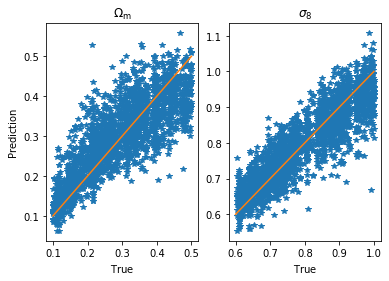

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'wspace': 0.2})

for ax in [ax1,ax2]:
  ax.set_xlabel(r'${\rm True}$')
ax1.set_ylabel(r'${\rm Prediction}$')

ax1.plot(params_T[:,0], params_N[:,0], ls='None', marker='*')
ax1.plot([0.1,0.5],[0.1,0.5])

ax2.plot(params_T[:,1], params_N[:,1], ls='None', marker='*')
ax2.plot([0.6,1.0],[0.6,1.0])

ax1.set_title(r'$\Omega_{\rm m}$')
ax2.set_title(r'$\sigma_8$')
 
plt.show()